<a href="https://colab.research.google.com/github/Radhesh-Sarma/Emotion-Detection/blob/main/GA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Genetic Algorithm for feature selection

In [30]:
import numpy
import sklearn.svm
from sklearn.linear_model import LogisticRegression
import numpy
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
from sklearn import model_selection
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
plt.style.use('seaborn')

In [31]:
def reduce_features(solution, features):
    selected_elements_indices = numpy.where(solution == 1)[0]
    reduced_features = features[:, selected_elements_indices]
    return reduced_features

def classification_accuracy(labels, predictions):
    correct = numpy.where(labels == predictions)[0]
    accuracy = correct.shape[0]/labels.shape[0]
    return accuracy*100

## Classifier Models

In [32]:
def cal_pop_fitness(pop, features, labels, train_indices, test_indices):
    accuracies = numpy.zeros(pop.shape[0])
    idx = 0

    for curr_solution in pop:
        reduced_features = reduce_features(curr_solution, features)
        train_data = reduced_features[train_indices, :]
        test_data = reduced_features[test_indices, :]

        train_labels = labels[train_indices]
        test_labels = labels[test_indices]

        #SVM CLASSIFIER
        SV_classifier = sklearn.svm.SVC(gamma='scale')
        SV_classifier.fit(X=train_data, y=train_labels)
        predictions = SV_classifier.predict(test_data)
        
        accuracies[idx] = classification_accuracy(test_labels, predictions)
        idx = idx + 1
    return accuracies

## Parent Selection

In [33]:
#rank selection
def rank_selection_mating_pool(pop, fitness, num_parents):
    # Selecting the best individuals in the current generation as parents for producing the offspring of the next generation.
    parents = numpy.empty((num_parents, pop.shape[1]))
    for parent_num in range(num_parents):
        max_fitness_idx = numpy.where(fitness == numpy.max(fitness))
        max_fitness_idx = max_fitness_idx[0][0]
        parents[parent_num, :] = pop[max_fitness_idx, :]
        fitness[max_fitness_idx] = -99999999999
    return parents

#tournament selection
def tournament_selection_mating_pool(pop, fitness, num_parents):
    # Selecting the best individuals in the current generation as parents for producing the offspring of the next generation.
    parents = numpy.empty((num_parents, pop.shape[1]))
    k=numpy.uint8(pop.shape[0]/2)
    for parent_num in range(num_parents):
      tournament = [random.randint(0,len(fitness)-1) for i in range(k)]
      fitnesses = [fitness[tournament[i]] for i in range(k)]
      parents[parent_num, :]=pop[tournament[fitnesses.index(max(fitnesses))]]
    return parents
  
#roulette wheel selection
def roulette_wheel_selection(pop, fitness, num_parents):
    # Selecting the best individuals in the current generation as parents for producing the offspring of the next generation.
    parents = numpy.empty((num_parents, pop.shape[1]))
    for parent_num in range(num_parents):
      randomList = random.choices(pop, weights=fitness, k=1) 
      parents[parent_num, :]=randomList[0]
    return parents

## Crossover

In [34]:
#uniform point crossover
def uniform_crossover(parents, offspring_size):
    offspring = numpy.empty(offspring_size)

    for k in range(offspring_size[0]):
        # Index of the first parent to mate.
        parent1_idx = k%parents.shape[0]
        # Index of the second parent to mate.
        parent2_idx = (k+1)%parents.shape[0]
        #probability matrix
        p=np.random.rand(offspring_size[1])

        for i in range(offspring_size[1]):
        # The new offspring will have its ith genes taken from the first parent if probability<0.5 and from the second parent if the probablility>=0.5.
          if p[i]<0.5:
            offspring[k,i:i+1] = parents[parent1_idx, i:i+1]
          else:
            offspring[k,i:i+1] = parents[parent2_idx, i:i+1]
    return offspring

#single point crossover
def single_crossover(parents, offspring_size):
    offspring = numpy.empty(offspring_size)
    # The point at which crossover takes place between two parents
    crossover_point = numpy.random.randint(low=0, high=offspring_size[1])

    for k in range(offspring_size[0]):
        # Index of the first parent to mate.
        parent1_idx = k%parents.shape[0]
        # Index of the second parent to mate.
        parent2_idx = (k+1)%parents.shape[0]
        # The new offspring will have its first half of its genes taken from the first parent.
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        # The new offspring will have its second half of its genes taken from the second parent.
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring

#two point crossover
def two_point_crossover(parents, offspring_size):
    offspring = numpy.empty(offspring_size)
    # The points at which crossover takes place between two parents
    crossover_point_1 = numpy.random.randint(low=0, high=offspring_size[1]-2)
    crossover_point_2 = numpy.random.randint(low=crossover_point_1+1, high=offspring_size[1])

    for k in range(offspring_size[0]):
        # Index of the first parent to mate.
        parent1_idx = k%parents.shape[0]
        # Index of the second parent to mate.
        parent2_idx = (k+1)%parents.shape[0]
        # The new offspring will have its first half of its genes taken from the second parent.
        offspring[k, 0:crossover_point_1] = parents[parent2_idx, 0:crossover_point_1]
        # The new offspring will have its second half of its genes taken from the first parent.
        offspring[k, crossover_point_1:crossover_point_2] = parents[parent1_idx, crossover_point_1:crossover_point_2]
        # The new offspring will have its third half of its genes taken from the second parent.
        offspring[k, crossover_point_2:] = parents[parent2_idx, crossover_point_2:]
    return offspring

## Mutation

In [35]:
#bit flip mutation
def bit_flip_mutation(offspring_crossover, num_mutations):
    mutation_idx = numpy.random.randint(low=0, high=offspring_crossover.shape[1], size=num_mutations)
    # Mutation changes a single gene in each offspring randomly.
    for idx in range(offspring_crossover.shape[0]):
        # The random value to be added to the gene.
        offspring_crossover[idx, mutation_idx] = 1 - offspring_crossover[idx, mutation_idx]
    return offspring_crossover

#swap mutation
def swap_mutation(offspring_crossover, num_mutations):
    mutation_idx_1 = numpy.random.randint(low=0, high=offspring_crossover.shape[1], size=num_mutations)
    mutation_idx_2 = numpy.random.randint(low=0, high=offspring_crossover.shape[1], size=num_mutations)
    # Mutation changes a single gene in each offspring randomly.
    for idx in range(offspring_crossover.shape[0]):
        # The random value to be added to the gene.
        temp=offspring_crossover[idx, mutation_idx_1]
        offspring_crossover[idx, mutation_idx_1] = offspring_crossover[idx, mutation_idx_2]
        offspring_crossover[idx, mutation_idx_2] = temp
    return offspring_crossover

#inverse mutation
def inverse_mutation(offspring_crossover, num_mutations):
    # Mutation changes a single gene in each offspring randomly.
    for idx in range(offspring_crossover.shape[0]):
      val=numpy.random.randint(low=0, high=offspring_crossover.shape[1]-num_mutations-1)
      temp=offspring_crossover[idx]
      np.flip(temp)
      for j in range(val,val+num_mutations):
        offspring_crossover[idx,j:j+1]=temp[j]
    return offspring_crossover

In [36]:
def normalize(dataset):
    dataNorm=((dataset-dataset.mean())/(dataset.std()))
    dataNorm["Sad"]=dataset["Sad"]
    return dataNorm

In [40]:
def select_mating_pool(new_population, fitness, num_parents_mating,type):
  if(type == "rank"):
    return rank_selection_mating_pool(new_population, fitness, num_parents_mating)
  if(type == "tournament"):
    return tournament_selection_mating_pool(new_population, fitness, num_parents_mating)
  if(type == "roulette"):
    return roulette_wheel_selection(new_population, fitness, num_parents_mating)


In [41]:
def select_cross_over(parents, offspring_size,type):
  if(type == "uniform"):
    return uniform_crossover(parents, offspring_size)
  if(type == "single"):
    return single_crossover(parents, offspring_size)
  if(type == "two_point"):
    return two_point_crossover(parents, offspring_size)

In [42]:
def select_mutation(offspring_crossover, num_mutations,type):
  if(type == "bit"):
    return bit_flip_mutation(offspring_crossover, num_mutations)
  if(type == "swap"):
    return swap_mutation(offspring_crossover, num_mutations)
  if(type == "inverse"):
    return inverse_mutation(offspring_crossover, num_mutations)

In [46]:
i = 0

In [43]:
def GA(sol_per_pop,num_parents_mating,num_mutations,num_generations,mating,crossover,mutation):
  df = pd.read_csv('Final.csv')
  df=df.drop(['face'],1)
  df=df.drop(['Unnamed: 0'],1)
  df=df.drop(['Unnamed: 0.1'],1)
  df=df.drop(['Unnamed: 0.1.1'],1)
  df = df.sample(frac = 1) 
  # print(df)
    
  df = normalize(df)

  x = np.array(df.drop(['Sad'],1))
  y = np.array(df['Sad'])

  data_inputs = x
  data_outputs = y

  num_samples = data_inputs.shape[0]
  num_feature_elements = data_inputs.shape[1]

  train_indices = numpy.arange(0,num_samples*0.7*(0.7), 1,int)
  val_indices = numpy.arange(num_samples*0.7*(0.7)+1,num_samples*0.7, 1,int)
  test_indices_1 = numpy.arange((num_samples*0.7)+1, num_samples*0.7+num_samples*0.3*0.7, 1,int)
  test_indices_2 = numpy.arange(num_samples*0.7+num_samples*0.7*0.3+1, num_samples, 1,int)
  # Defining the population shape.
  pop_shape = (sol_per_pop, num_feature_elements)
  print("Mating : " + str(mating))
  print("Crossover : " + str(crossover))
  print("Mutation : " + str(mutation))
  # Creating the initial population.
  new_population = numpy.random.randint(low=0, high=2, size=pop_shape)
  best_population=new_population

  best_outputs = []
  for generation in range(num_generations):
    # if(generation%100 == 0):
    #   print("Generation : ", generation)
    # Measuring the fitness of each chromosome in the population.
    fitness = cal_pop_fitness(new_population, data_inputs, data_outputs, train_indices, val_indices)
    # print("Fitness")
    # print(fitness)
    # print(numpy.max(fitness))
    if generation>1 and numpy.max(fitness)>=best_outputs[-1]:
      best_population=new_population

    best_outputs.append(numpy.max(fitness))
    # The best result in the current iteration.
    # print("Best fitness so far : ", best_outputs[-1])

    # Selecting the best parents in the population for mating.
    parents = select_mating_pool(new_population, fitness, num_parents_mating,type = mating)
    # print("Parents")
    # print(parents)

    # Generating next generation using crossover.
    offspring_crossover = select_cross_over(parents, offspring_size=(pop_shape[0]-parents.shape[0], num_feature_elements),type = crossover)
    # print("Crossover")
    # print(offspring_crossover)

    # Adding some variations to the offspring using mutation.
    offspring_mutation = select_mutation(offspring_crossover, num_mutations=num_mutations,type = mutation)
    # print("Mutation")
    # print(offspring_mutation)

    # Creating the new population based on the parents and offspring.
    new_population[0:parents.shape[0], :] = parents
    new_population[parents.shape[0]:, :] = offspring_mutation
    # Getting the best solution after iterating finishing all generations.
  # At first, the fitness is calculated for each solution in the final generation.
  fitness = cal_pop_fitness(best_population, data_inputs, data_outputs, train_indices, val_indices)
  # Then return the index of that solution corresponding to the best fitness.
  best_match_idx = numpy.where(fitness == numpy.max(fitness))[0]
  best_match_idx = best_match_idx[0]

  best_solution = best_population[best_match_idx, :]
  best_solution_indices = numpy.where(best_solution == 1)[0]
  best_solution_num_elements = best_solution_indices.shape[0]
  best_solution_fitness = fitness[best_match_idx]

  print("best_solution : ", best_solution)
  print("Selected indices : ", best_solution_indices)
  print("Number of selected features : ", best_solution_num_elements)
  print("Best solution fitness(Training accuracy) : ", best_solution_fitness)



  
  features=df.columns
  Dict = {}
  for i in range(0,best_solution_num_elements):
    Dict[i]=features[best_solution_indices[i]]
  import operator
  sorted_x = sorted(Dict.items(), key=operator.itemgetter(1),reverse=True)
  print("Printing features in the best feature subset")
  x=0
  for i in sorted_x:
    print(x,":",i[1])
    x=x+1


  print(best_outputs) 
  
  plt.plot(best_outputs)
  plt.xlabel("No of Generations")
  plt.ylabel("$Fitness(\Theta)$")
  plt.title("Plot of Fitness Function v/s Generations")
  plt.show()   



  
  fitness = cal_pop_fitness(best_population, data_inputs, data_outputs, test_indices_1, test_indices_2)
  testacc=numpy.max(fitness)
  print("Testing Accuracy of the best solution is : ", testacc)


In [ ]:
matings = ["rank","tournament","roulette"]
cross_overs = ["uniform","single","two_point"]
mutations = ["bit","swap","inverse"]

for mating in matings:
  for cross_over in cross_overs:
    for mutation in mutations:
      GA(sol_per_pop = 20,num_parents_mating = 10,num_mutations = 70,num_generations = 100,mating = mating,crossover = cross_over,mutation = mutation)

Mating : rank
Crossover : uniform
Mutation : inverse
best_solution :  [1 0 0 1 1 1 0 0 0 0 0 1 1 1 0 1 1 1 1 0 0 1 1 0 1 1 0 0 1 0 0 1 1 1 1 0 1
 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 1 1 0 1 1 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1
 1 1 1 1 1 1 0 0 0 1 0 1 0 1 0 1 1 1 1 0 1 1 0 1 1 0 0 0 1 0 1 1 0 1 1 0 1
 0 1 0 0 1 0 0 0 0 1 1 1 1 1 1 1 0 0 1 1 0 0 0 1 1 1 1 1 0 1 0 1 0 0 1 1 1
 0 1 0 1 1 1 0 1 1 0 0 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 0 1 0 0 0 1 0
 1 1 0 1 1 0 0 0 1 0 1 1 0 1 1 1 1 1 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 1 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 0 1 0 0 0 1 0 1 0 0 1 1 0 1 1 1 1 0
 1 1 0 1 0 1 0 0 1 0 1 1 1 0 0 0 1 1 0 1 1 1 0 0 1 0 1 1 1 0 0 0 0 1 1 0 1
 1 0 1 0 1 0 0 0 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 0 1 0 1 0 1 0 1 1 1 1
 1 0 0 0 1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 1 1 0 1 1 0 0 1 0 1 1 1
 1 1 0 1 0 1 0 0 1 1 1 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 1 1
 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 1 1 0 1 0 1 1 0 1 0 1 0 0 1 0 1 1 0 0 1 0 1
 1 1 0 1 1 1 1 0 1 0 1 0 1 0 0

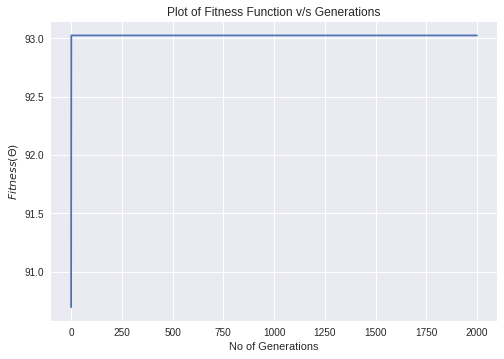

Testing Accuracy of the best solution is :  83.33333333333334


In [45]:
GA(sol_per_pop = 20,num_parents_mating = 10,num_mutations = 70,num_generations = 2000,mating = "rank",crossover = "uniform",mutation = "inverse")